# EDA & Data Wrangling
In this work I use 3 different data sets each of which have different structures. Each data sets contains more information then needed in this work. The goal in this notebook is to prepare all three data sets by cleaning and transforming them to get the relavant informations: crop yield as a response variable and the agro-climatic indicators as features for the selected states. Due to structural differences 3 different data analysis tools need to be used. These datasets are:

1. The crop yield data for alfalfa, corn and soybeans for each state in the U.S. The goal is to clean the data and get the `State`, `Year` and `Value` (Yield) columns for the selected states. `Pandas` package will be used for analysis and manipulation.

2. The data for the coordinates of the state boundaries. This data is used to select the region of interest in the climate dataset. `Geopandas` and `Salem` packages are used for this data.

3. Agro-climatic indicators, which include fundemental climate variables, such as tempereture and rain, and the ones that are derived from them such as biologically available degree days. This dataset is a time series of 26 agro-climatic indicators with additional two spatial coordinates (latitude & longtitude). `Xarray` package with `dask` integation is used to analysis and manipulation. The entire dataset comes as three separate netcdf file, with either dekadal, seasonal or annual aggregation of certain variables. The goal is to 
    * annually aggregate all the indicators and merge them into a single xarray dataset, 
    * using the state boundaries data, get the spatial averages of each variables for selected states,
    * convert the final data to pandas dataframe
    * merge the climate indicators and crop yield data into a single pandas dataframe

Since All three data sets are raw the data exploration and data wrangling steps are kind of mixed.

In [1]:
import os
import cdsapi

import numpy as np
import pandas as pd
import pandas_profiling
import geopandas
import netCDF4
import xarray as xarr # pandas based library for 
            # labeled data with N-D tensors at each dimension
import salem

import matplotlib.pyplot as plt
%matplotlib inline 
import cartopy
import cartopy.crs as ccrs
import seaborn as sns

from statsmodels.tsa.tsatools import detrend

## The Soybeans Production Data
Crop Data is obtained from: [United States Department of Agriculture - National Agricultural Statistics  Service](https://quickstats.nass.usda.gov/results/347988B6-8746-305D-9147-D1A31FE09FD2)

Here is the map that shows where these crops are produced
Source: https://www.nass.usda.gov/Charts_and_Maps/Crops_County/al-ha.php

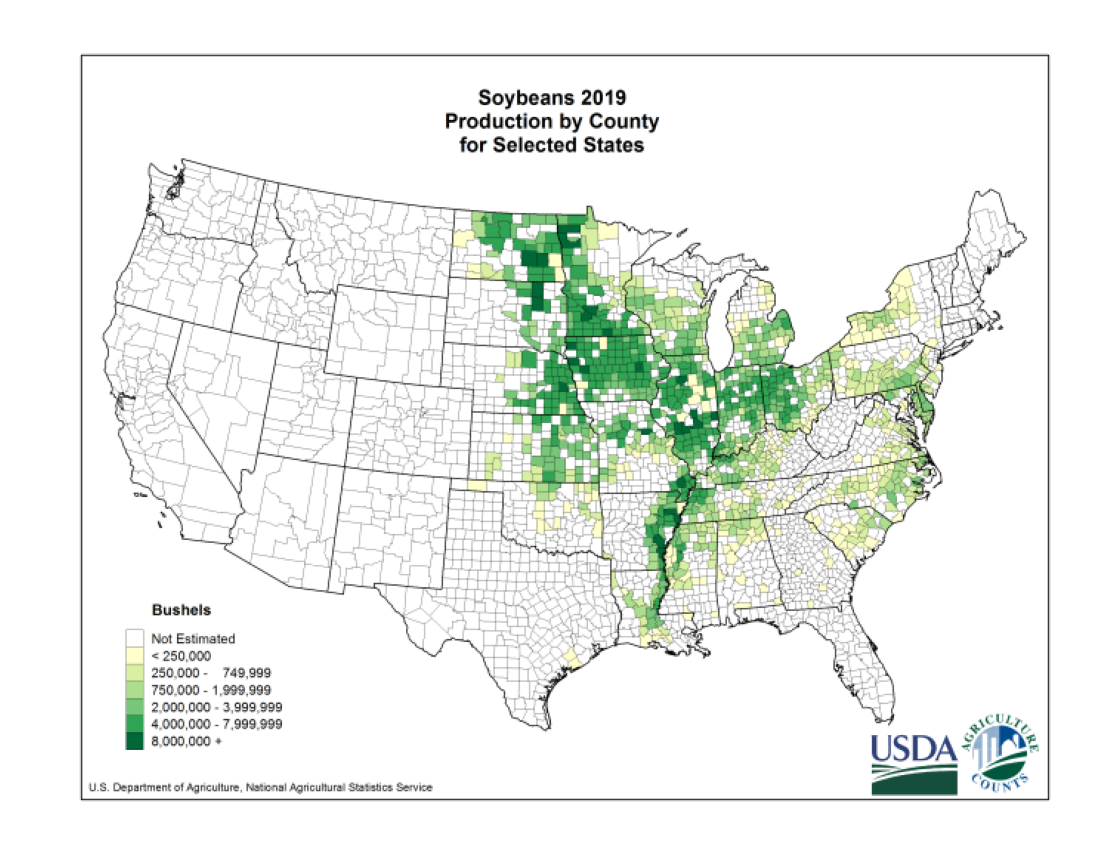

In [2]:
# Getting Soybeans Production Map
import matplotlib as mpl

mpl.rc('figure', figsize = (18,12))
fig = plt.figure()

# Get the images from the source and Plot them 
ax = fig.add_subplot()
a = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/SB-PR-RGBChor.png")
ax.imshow(a)

ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
plt.tight_layout()
plt.show()
plt.close()

mpl.rcParams.update(mpl.rcParamsDefault)

<div class="span5 alert alert-info">
The crop production data contains many fields, but we only need the yield values, time and state columns at the end. However, some of the other fields will be used to filter out the entries irrelivant to the purpose of this work.
</div>

In [3]:
#  Now Reading All the Crop Data that we are interested to a dataframe
path = "Data/"
# Let's read the crops data as a dataframe
df_soy = pd.read_csv('../Data/soybeans_nonirrigated.csv')
df_soy.head(3).T

,0,1,2
Program,SURVEY,SURVEY,SURVEY
Year,2010,2010,2010
Period,YEAR,YEAR,YEAR
Week Ending,NaN,NaN,NaN
Geo Level,COUNTY,COUNTY,COUNTY
State,ARKANSAS,ARKANSAS,ARKANSAS
State ANSI,5,5,5
Ag District,EAST CENTRAL,EAST CENTRAL,EAST CENTRAL
Ag District Code,60,60,60
County,CRITTENDEN,CROSS,LEE


In [4]:
# Check the info of these columns
df_soy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Program           916 non-null    object 
 1   Year              916 non-null    int64  
 2   Period            916 non-null    object 
 3   Week Ending       0 non-null      float64
 4   Geo Level         916 non-null    object 
 5   State             916 non-null    object 
 6   State ANSI        916 non-null    int64  
 7   Ag District       916 non-null    object 
 8   Ag District Code  916 non-null    int64  
 9   County            916 non-null    object 
 10  County ANSI       916 non-null    int64  
 11  Zip Code          0 non-null      float64
 12  Region            0 non-null      float64
 13  watershed_code    916 non-null    int64  
 14  Watershed         0 non-null      float64
 15  Commodity         916 non-null    object 
 16  Data Item         916 non-null    object 
 1

Not all these columns are needed. The only relevant columns are these: `State`, `County`, `Commodity`, `Data Item`(that is the column associated with the Value column along with State colums), `Domain`, `Value` (This is what we are trying to predict). 

* Let's drop all nan values. None of the columns we are interested in has any nan values.


<div class="span5 alert alert-info">
<b>Dropping missing values</b>
    </div>

In [5]:
# Missing Values
nan=pd.DataFrame(df_soy.isnull().sum().sort_values(ascending=False), columns = ['NULL values'])
nan.query('`NULL values` > 0').T

,CV (%),Zip Code,Week Ending,Watershed,Region
NULL values,916,916,916,916,916


In [6]:
# We can drop all the columns with nan values at once
df_soy.dropna(axis=1, inplace=True)

# Fixing the index
df_soy.reset_index(drop=True, inplace=True)
print(df_soy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Program           916 non-null    object 
 1   Year              916 non-null    int64  
 2   Period            916 non-null    object 
 3   Geo Level         916 non-null    object 
 4   State             916 non-null    object 
 5   State ANSI        916 non-null    int64  
 6   Ag District       916 non-null    object 
 7   Ag District Code  916 non-null    int64  
 8   County            916 non-null    object 
 9   County ANSI       916 non-null    int64  
 10  watershed_code    916 non-null    int64  
 11  Commodity         916 non-null    object 
 12  Data Item         916 non-null    object 
 13  Domain            916 non-null    object 
 14  Domain Category   916 non-null    object 
 15  Value             916 non-null    float64
dtypes: float64(1), int64(5), object(10)
memory u

There are some constant values and some entries that are not needed. Let's remove them from the df_crop, but first let's take a look at the number of unique values in each column in a bar plot

In [7]:
pd.DataFrame(df_soy.nunique()).T

,Program,Year,Period,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,watershed_code,Commodity,Data Item,Domain,Domain Category,Value
0,1,31,1,1,2,2,8,7,27,29,1,1,1,1,1,171


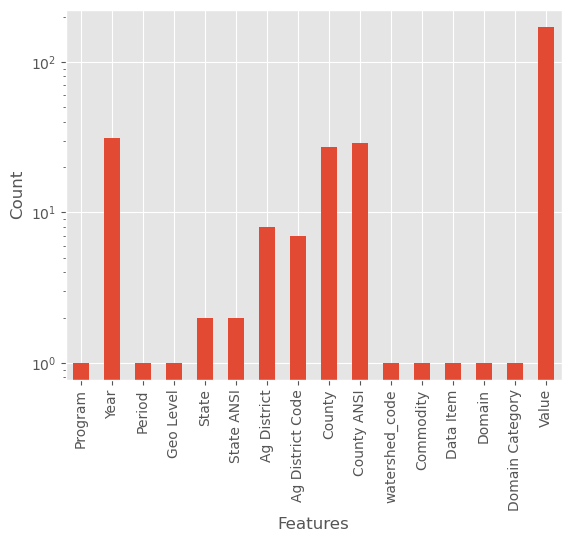

In [8]:
# Plotting Number of Unique Values
plt.style.use('ggplot')
df_soy.nunique().plot(kind='bar', logy=True)
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()
plt.close()
# Find those columns with constant values

<div class="span5 alert alert-info">
There are more columns than we need. Let's drop the ones we will not use. <b>We do not need constant value columns</b>
    </div>

In [86]:
# Getting rid of the columns with constant values
nunq = df_soy.nunique()
dropped = []
for clm in df_soy:
    if nunq.loc[clm] == 1:
        df_soy = df_soy.drop(clm, axis=1)
        dropped.append(clm)
print(df_soy.nunique(),'\n\n')
print(f'dropped columns: {dropped}')

Year                 31
State                 2
State ANSI            2
Ag District           8
Ag District Code      7
County               27
County ANSI          29
Value               171
County_ID            31
dtype: int64 


dropped columns: []


In [10]:
# Now fixing the index
df_soy = df_soy.reset_index(drop=True)

In [91]:
df_soy

,Year,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Value,County_ID
0,2010,ARKANSAS,5,EAST CENTRAL,60,CRITTENDEN,35,28.0,5035
1,2010,ARKANSAS,5,EAST CENTRAL,60,CROSS,37,21.6,5037
2,2010,ARKANSAS,5,EAST CENTRAL,60,LEE,77,15.0,5077
3,2010,ARKANSAS,5,EAST CENTRAL,60,LONOKE,85,19.0,5085
4,2010,ARKANSAS,5,EAST CENTRAL,60,PHILLIPS,107,23.5,5107
...,...,...,...,...,...,...,...,...,...
911,1980,NEBRASKA,31,SOUTHEAST,90,GAGE,67,26.0,31067
912,1980,NEBRASKA,31,SOUTHEAST,90,JEFFERSON,95,25.0,31095
913,1980,NEBRASKA,31,SOUTHEAST,90,JOHNSON,97,24.0,31097
914,1980,NEBRASKA,31,SOUTHEAST,90,NEMAHA,127,28.0,31127


## Preparing Yield data for modelling
* Detrend the Yield data for each state
* Concact the detrended state data back to a dataframe

<a id='PrepareYieldModelling'></a>

<div class="span5 alert alert-info">
    Create a new unique County ID in df_soy data so that counties with the same name can be separeted ( Note that counties with the same name also have the same ANSI code)
    </div>

In [132]:
df_soy['County_ID'] = df_soy['State ANSI']*1000 + df_soy['County ANSI']

Rearrange the data in a way that each counties values from 1980-2010 come subsequently following another counties time series values.
Doing this helps making analysis and modelling processes simplier.

In [133]:
# creating new dataframe for soybeans with the structure matching climate data
soy_yield = df_soy.sort_values(['County_ID','Year'])
soy_yield.reset_index(inplace=True, drop=True)

In [134]:
soy_yield

,Year,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Value,County_ID
0,1980,ARKANSAS,5,EAST CENTRAL,60,CRITTENDEN,35,17.0,5035
1,1981,ARKANSAS,5,EAST CENTRAL,60,CRITTENDEN,35,19.0,5035
2,1982,ARKANSAS,5,EAST CENTRAL,60,CRITTENDEN,35,26.6,5035
3,1983,ARKANSAS,5,EAST CENTRAL,60,CRITTENDEN,35,13.0,5035
4,1984,ARKANSAS,5,EAST CENTRAL,60,CRITTENDEN,35,26.0,5035
...,...,...,...,...,...,...,...,...,...
911,2006,NEBRASKA,31,NORTHEAST,30,WAYNE,179,44.0,31179
912,2007,NEBRASKA,31,NORTHEAST,30,WAYNE,179,51.0,31179
913,2008,NEBRASKA,31,NORTHEAST,30,WAYNE,179,39.0,31179
914,2009,NEBRASKA,31,NORTHEAST,30,WAYNE,179,49.0,31179


### Detrending Yield Data
<div class="span5 alert alert-warning">
Since this study is about anomalies, detrending before splitting the data to train and test wouldn't cause any significant data leakage because trends in the data are mostly related to external factors such as technological development, human behaviours etc. rather than climate change which happens to have similar trend (although not by chance, they do not have direct cause and effect relationship in the context of crop yield).

In [135]:
# detrending each state separately
df_list = []
# Collect unique county codes in a list
soy_counties = list(soy_yield['County_ID'].unique())
for countyID in soy_counties:
    df = soy_yield.query('County_ID == @countyID').copy()
    df.loc[:,'Value'] = detrend(df['Value']).values
    df_list.append(df)
# collect the detrended counties yield data in a single dataframe again
soy_yield = pd.concat(df_list, axis=0)

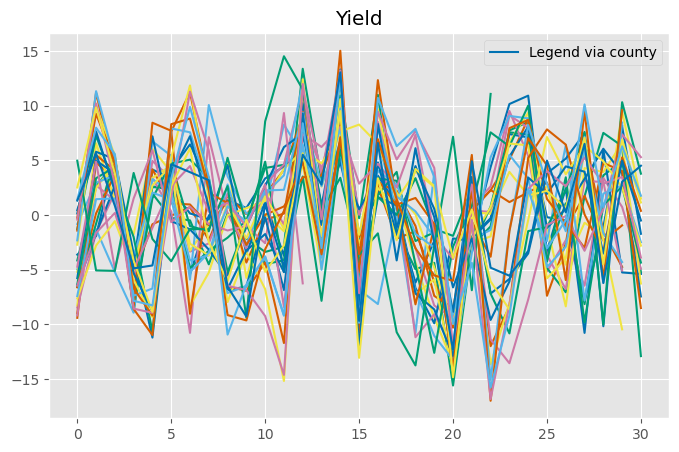

In [136]:
# Let's create a function to plot counties yield data as time series
counties = iter(soy_counties)
def plot_var(var):
    fig, ax = plt.subplots(figsize=(8,5))
    for df in df_list: 
        stt = next(counties)
        if var == 'Value':
            df[var].reset_index(drop=True).plot(ax=ax, label=stt)
            plt.title('Yield')
        else:
            df[var].plot(ax=ax, label=stt)
            plt.title(agro_clim[var].long_name)
    return
plot_var('Value')
plt.legend(["Legend via county"])
plt.savefig('../Figures/YieldByCounty.png')
#interact plots don't appear on github
# plot_var('GSL')

As seen in the plot above, soybeans yield data has been detrended by individually detrending counties. As expected, many counties have similar fluctuations in time. To see this more clear let's plot the state distributions as a time series.

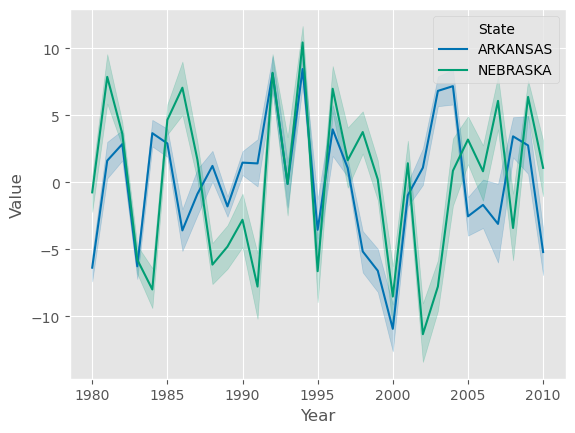

In [209]:
sns.lineplot(x='Year', y='Value', hue='State', data=soy_yield)
plt.savefig('../Figures/YieldDistrByStates.png')

### Missing Years
<div class="span5 alert alert-info">
Let's see if all the counties have the records for all the years. If they have all the years then the value counts for each county should yield 31. </div>

In [156]:
val_counts = soy_yield['County_ID'].value_counts()
val_counts[val_counts < 31]

31097    30
5063     30
31039    30
5147     30
5079     30
5085     30
5145     30
31127    30
31111    23
5071     20
5125     13
Name: County_ID, dtype: int64

In [161]:
val_counts[val_counts == 30].index

Int64Index([31097, 5063, 31039, 5147, 5079, 5085, 5145, 31127], dtype='int64')

<div class="span5 alert alert-info">
Some counties have missing years. Let's fill the missing values for those which only have 1 missing value, and drop the rest of them. Let's fill a missing year by the state mean for that year (remember how similar the yield values for counties within the same state).</div>

In [210]:
# Create a set for the years between 1980 and 2010
year_set = {i for i in np.arange(1980,2011)}
# loop through the counties with a single missing year
countID_missing1 = val_counts[val_counts == 30].index
for countID in countID_missing1:
    # create a set for the years that the county has a record
    county_years = {x for x in soy_yield.query('County_ID == @countID')['Year']}
    # Use the difference in sets to find the missing year
    missing_year = year_set.difference(county_years).pop()
    print(f'missing year for county id {countID} is {missing_year}')
    # Find the state Ansi of the county
    state_id = soy_yield.query('County_ID == @countyID').iloc[0,2]
    # Calculate the state mean for the missing year
    state_mean = soy_yield.sort_values(['State', 'Year']).query(
        'Year == @missing_year and `State ANSI` == @state_id')['Value'].mean()
    print(f'state mean = {state_mean}')


missing year for county id 31097 is 2010
state mean = 1.072759856630849
missing year for county id 5063 is 2007
state mean = 6.066613231845633
missing year for county id 31039 is 2010
state mean = 1.072759856630849
missing year for county id 5147 is 2007
state mean = 6.066613231845633
missing year for county id 5079 is 2009
state mean = 6.363046594982097
missing year for county id 5085 is 2009
state mean = 6.363046594982097
missing year for county id 5145 is 2007
state mean = 6.066613231845633
missing year for county id 31127 is 2010
state mean = 1.072759856630849


In [199]:
df_soy.sort_values(['State', 'Year']).query('Year == 2010 and `State ANSI` == 5')['Value'].mean()

20.5875

Save the soybeans production data to disk

In [11]:
df_soy.to_pickle('../Data/df_soy.pkl')

## Preparing the Agroclimatic Indicators Data
<table class="abstract-description abstract-table">
        <tbody><tr><th colspan="2">DATA DESCRIPTION</th>
        
</tr><tr><th>Data type</th><td>Gridded</td></tr>
<tr><th>Projection</th><td>Regular latitude-longitude grid</td></tr>
<tr><th>Horizontal coverage</th><td>Global</td></tr>
<tr><th>Horizontal resolution</th><td>0.5° x 0.5°</td></tr>
<tr><th>Vertical coverage</th><td>Surface</td></tr>
<tr><th>Vertical resolution</th><td>Single level</td></tr>
<tr><th>Temporal coverage</th><td>1951 to 2099</td></tr>
<tr><th>Temporal resolution</th><td>Variable dependent: 10-day, seasonal or annual</td></tr>
<tr><th>File format</th><td>NetCDF-4</td></tr>
<tr><th>Conventions</th><td>Climate and Forecast (CF) Metadata Convention v1.7</td></tr>
<tr><th>Update frequency</th><td>No updates expected</td></tr>
</tbody></table>


In [12]:
# Define Custom functions to use in this sub-section

def grid_mean(ds):
    """lat-lon mean of the entire dataset
    accounting for the actual grid areas"""
    weight = np.cos(np.deg2rad(ds.lat))
    cos_lat_weighted_mean = ds.weighted(weight).mean(("lon", "lat"))

    return cos_lat_weighted_mean


def anomaly(da):
    """calculate anomaly"""

    clim = da.mean(dim='time')
    anom = da - clim

    return anom

def covmat(a,b):
    """covmat(a,b): calculate covariance between vector a and each grid point of matrix b
     returns a matrix with dimensions of b"""

    b1 = b.values
    s1 = np.shape(b1)
    a1 = a.values
    b1 = b1.reshape(s1[0],s1[1]*s1[2])

    a1 = a1 - np.average(a1);
    b1 = b1 - np.average(b1,axis=0)

    c1 = np.matrix(a)*np.matrix(b1)
    c1 = c1.reshape(s1[1],s1[2])/s1[0]
    c1 = xarr.DataArray(c1,dims=['lat','lon'],coords={'lat': b.lat, 'lon': b.lon})

    return c1


def detrend_2d(da):
    """linear detrend of 2D data set (lat x lon x time)
    returns anomaly"""

    da1 = anomaly(da)

    t1 = xarr.DataArray(np.arange(len(da1.time)),dims='time',coords={'time': da1.time})
    slope = covmat(t1,da1)/np.std(t1)**2

    da1 -= slope*t1 # remove linear trend
    da2 = anomaly(da1)

    return da2

 #### Download the data using CDSAPI

In [13]:
# # This cell needs to be run only once, when the agroclimatic indicators are downloaded from the source

# c = cdsapi.Client()

# c.retrieve(
#     'sis-agroclimatic-indicators',
#     {
#         'origin': 'era_interim_reanalysis',
#         'variable': [
#             'biologically_effective_degree_days', 'frost_days', 'heavy_precipitation_days',
#             'ice_days', 'maximum_of_daily_maximum_temperature', 'maximum_of_daily_minimum_temperature',
#             'mean_of_daily_maximum_temperature', 'mean_of_daily_mean_temperature', 'mean_of_daily_minimum_temperature',
#             'mean_of_diurnal_temperature_range', 'minimum_of_daily_maximum_temperature', 'minimum_of_daily_minimum_temperature',
#             'precipitation_sum', 'simple_daily_intensity_index', 'summer_days',
#             'tropical_nights', 'very_heavy_precipitation_days', 'wet_days',
#         ],
#         'experiment': 'historical',
#         'temporal_aggregation': '10_day',
#         'period': '198101_201012',
#         'format': 'zip',
#     },
#     'download.zip')

#### Reading the data as an Xarray dataset
<div class="span5 alert alert-info">
The agroclimatic data is a gridded time series data. It comes as a Netcdf file, which contains the latitude, longtitude and altitude coordinates and time dimension as well as 26 agroclimatic indicators. Although pandas data frame can be used to import this data, it would be too cumbersome to do so due to multidimensional structure of the data. Xarray library on the other hand is built exactly for handling this type of dataset. 
<br><br>
Besides xarray datasets can integrate with dask for parallelization. I will use this feature to read the dekadal data with chunks so that processing the data wouldn't require too much memory
</div>

In [14]:
# Read the data Path where they are stored on the Computer
#data_dir = input('Path to the data\n')
paths = []
for folder in ['dekadal', 'seasonal', 'annual']:
    paths += [os.path.join('C:\\'
                'Users',
                'kurt_',
                'Data',
                'agroclimate',
                 folder,'')]
dekadal_dir, seasonal_dir, annual_dir = paths

#### Importing the Indicators
<div class="span5 alert alert-info">
Each agroclimatic indicator is stored in the disk as a single netcdf file. <b>All the files will be merged into a single xarray dataset which will be divided into chunks and parallelization with dask will be enabled to speed up the operations</b>
</div>

In [15]:
# Import data as xarray dataset from the directory
def read_nc_files(data_dir, chunk, dask=False):
    dask = True
    if dask:
        # Import with dask
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                                  combine='by_coords', 
                                 chunks= chunk, # first spatial subsetting operations will be made.
                                 engine='netcdf4') # if available, h5netcdf engine is fatser than netcdf4
    else:
        # Import without dask for debugging
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                              combine='by_coords', engine='netcdf4')
    return dt
clim_dek = read_nc_files(dekadal_dir, chunk={'time':20}, dask=True) # The size on the disk is 2.4gb
clim_seas = read_nc_files(seasonal_dir, chunk=None)
clim_ann = read_nc_files(annual_dir, chunk=None)

#### Selecting U.S.
Since the final model will only apply to some continental U.S. states, there is no need to work on global data. Removing the rest of the world's data significantly reduces memory demand.

In [17]:
# selecting U.S. only
clim_dek = clim_dek.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_seas = clim_seas.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_ann = clim_ann.sel(lon=slice(-140, -50) ,lat=slice(15,60))

# Write them to disk and re-read them without chunks
ds_dict = {'dekadal':clim_dek, 'seasonal': clim_seas,
           'annual': clim_ann}
for ds_key in ds_dict:
    # write the data into folders with paths dek_dir, seas_dir or ann_dir 
    ds_dict[ds_key].to_netcdf(f'{eval(ds_key+"_dir")}{ds_key}.nc')

In [35]:
# Reading the us data from the disk
clim_dek = xarr.open_dataset(dekadal_dir+"dekadal.nc", chunks={'time':135}) # this is now only ~300 mb. No need chunks
clim_seas = xarr.open_dataset(seasonal_dir+"seasonal.nc")
clim_ann = xarr.open_dataset(annual_dir+"annual.nc")

### Exploring the agroclimatic indicators datasets

In [36]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [37]:
def plot_2d(var, time):
    # ploting the first time step to check the selected area
    ax = clim_dek[var].isel(time=time).plot(figsize=(10,5))
    plt.show()
    return ax
interact(plot_2d, var=[i for i in clim_dek if i!= 'time_bounds'], time=(1,1080,36))

interactive(children=(Dropdown(description='var', options=('BEDD', 'DTR', 'FD', 'ID', 'R10mm', 'R20mm', 'RR', …

<function __main__.plot_2d(var, time)>

In [38]:
def explore_ds(dt):
    for var in dt:
        print(f'{var}: {dt[var].attrs}')
    # Let's select the first time step and plot the 2m-air temperature

    # Let's check the dimensions
    for dim in dt.dims:
        dimsize = dt.dims[dim]
        print(f'\nData has {dimsize} {dim} ')
        if dim == 'latitude':
            print(f' latitudes: from {float(dt[dim].min())} degree South',
         f'to {float(dt[dim].max())} degree North')
        if dim == 'longitude':
            print(f' Longitudes: from {float(dt[dim].max())} degree East',
         f'to {float(dt[dim].min())} degree West')
        if dim == 'time':
            print(f'time: from {pd.to_datetime(dt["time"].min().values)} to\
                  {pd.to_datetime(dt["time"].max().values)} ')

#### Dekadal variables

Dekadal dataset have 2 spatial, one time coordinates and 15 variables. Now let's see what each of these variables are.

In [39]:
explore_ds(clim_dek)

time_bounds: {}
BEDD: {'units': 'degrees_C', 'long_name': 'Biologically Effective Degree Days', 'cell_methods': 'time: sum'}
DTR: {'units': '', 'long_name': 'Mean of diurnal temperature range', 'cell_methods': 'time: mean'}
FD: {'units': 'day', 'long_name': 'Frost days (minimum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
ID: {'units': 'day', 'long_name': 'Ice days (maximum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
R10mm: {'units': 'day', 'long_name': 'Heavy precipitation days (precipitation >= 10 mm)', 'cell_methods': 'time: sum'}
R20mm: {'units': 'day', 'long_name': 'Very heavy precipitation days (precipitation >= 20 mm)', 'cell_methods': 'time: sum'}
RR: {'units': 'mm', 'long_name': 'Precipitation sum', 'cell_methods': 'time: sum'}
RR1: {'units': 'day', 'long_name': 'Wet days (precipitation >= 1 mm)', 'cell_methods': 'time: sum'}
SDII: {'units': 'mm', 'long_name': 'Simple daily intensity index for wet days (mm/wet day)', 'cell_methods': 'time: mean'}
SU:

#### Seasonal variables

Seasonal dataset have 2 spatial, one time coordinates and 7 variables. Now let's see what each of these variables are.

In [40]:
explore_ds(clim_seas)

time_bounds: {}
CDD: {'units': 'day', 'long_name': 'Maximum number of consecutive dry days (precipitation < 1 mm)', 'cell_methods': 'time: maximum'}
CFD: {'units': 'day', 'long_name': 'Maximum number of consecutive frost days (minimum temperature < 0 degrees_C)', 'cell_methods': 'time: maximum'}
CSDI: {'units': 'day', 'long_name': 'Cold-spell duration index', 'cell_methods': 'time: sum'}
CSU: {'units': 'day', 'long_name': 'Maximum number of consecutive summer days(temperature > 25 degrees_C)', 'cell_methods': 'time: maximum'}
CWD: {'units': 'day', 'long_name': 'Maximum number of consecutive wet days (precipitation >= 1 mm)', 'cell_methods': 'time: maximum'}
WSDI: {'units': 'day', 'long_name': 'Warm-spell duration index', 'cell_methods': 'time: sum'}
WW: {'units': 'day', 'long_name': 'Warm and wet days', 'cell_methods': 'time: sum'}

Data has 2 bounds 

Data has 90 lat 

Data has 180 lon 

Data has 119 time 
time: from 1981-04-16 00:00:00 to                  2010-10-16 00:00:00 


#### Annaul variable
There is only a single annual variable: Growing Season Length

In [41]:
explore_ds(clim_ann)

time_bounds: {}
GSL: {'units': 'day', 'long_name': 'Growing season length', 'cell_methods': 'time: sum'}

Data has 2 bounds 

Data has 90 lat 

Data has 180 lon 

Data has 30 time 
time: from 1981-07-01 00:00:00 to                  2010-07-01 00:00:00 


#### Droping variables Not Needed
<div class="span5 alert alert-info">
Some of these variables are related to variation in the climate. However, in this study trend in climate variables will be removed and climate change is not studied. Hence some of these variables will be removed.
    </div>

In [42]:
# create a list of variables to keep
vars_to_keep = ['BEDD', 'CSDI', 'FD', 'GSL', 'R10mm', 
        'ID', 'CDD','CFD', 'CSU', 'CWD', 'TX',
       'TG', 'DTR', 'RR', 'SU', 'TR', 'R20mm',
       'WW', 'WSDI', 'RR1']
# Drop all but these variables in the vars_to_keep
def DropVars(ds):
    for var in ds:
        if var not in vars_to_keep:
            ds = ds.drop_vars(var)
    return ds
    
clim_dek = DropVars(clim_dek)

## Merging All Climate Datasets 
**(Dekadal, Seasonal, Annual)**

<div class="span5 alert alert-warning">
<ul> <li>Some variables are aggregated as sum of all the occurence during the dekadal, seasonal or annual period, while some are averaged.</li> 
    <li>The aggregation method is recorded in "cell_methods" attribute of the variable.</li> 
    <li>Using cell_methods for each variable annual aggregations will be calculated.</li>
    <li>All three datasets will be merged into a single one.</li>
    <li>Then, All the climate parameters will be spatially averaged through the state level.</li></ul>
</div>

#### Resampling Dekadal Variables
**The planting season roughly start on May and the harvesting ends before December at each state. Therefore, let's select only this months and then yearly resample all the variables**

Let's define a function to resample the datasets. Resample method for each variable should be choosen from it's cell_method, which tells how the variable is agregated through time. 

In [18]:
def resample_with_cell_method(ds, frq='AS'):
    """Resample the input dataset to a frequency given as frq as input
    with resampling method unique for each variable, in accordance with 
    their cell method, how they originally aggregated """

    # Resampling annualy
    ds_resampled = ds.resample(time=frq, keep_attrs=True)
    
    # creating a list to merge indpendently resampled variables
    dt_arrays_to_merge = []

    # iterate over each variable
    for var in ds:
        # skip time_bounds variable
        if var == "time_bounds":
            continue
        # resampling method based on each variable's cell_method
        if "mean" in ds[var].cell_methods:
            vars()[var] = ds_resampled.mean(keep_attrs=True)[var]
        elif "maximum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.max(keep_attrs=True)[var]
        elif "minimum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.min(keep_attrs=True)[var]
        elif "sum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.sum(keep_attrs=True)[var]
        # appending resampled variable to the list
        dt_arrays_to_merge.append(eval(var))

    # Merge all variables back to a dataset
    return xarr.merge(dt_arrays_to_merge)

In [44]:
# Selecting the relavant months in each year
sel_dates = clim_dek.time.values[(clim_dek.time.dt.month > 4) & (clim_dek.time.dt.month < 12)]
clim_dek_subset = clim_dek.sel(time=sel_dates)

In [46]:
# Resample the dekadal data to yearly
clim_dek_to_ann = resample_with_cell_method(clim_dek_subset)
clim_dek_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

#### Resampling Seasonal Variables
<div class="span5 alert alert-info">
We need the data for the months covering May - November. Either Spring, Summer and Fall should be selected to cover all the growing season or we could just select summer and Fall, since the values agregated through March and April should have no affect on the soybean production, and yet they are included in the spring data. Besides, none of the southern states, where the planting season starts earlier, included in the soybean yield data. For the states included in the data, the most active planting season usualy starts near the end of the May <b style="color:red">*</b>.

Thus, I will only select summer and fall seasons for the afferomentioned reasons 

<b style="color:red">\*Source:</b> https://swat.tamu.edu/media/90113/crops-typicalplanting-harvestingdates-by-states.pdf
    </div>

In [47]:
# Selecting the summer and fall seasons in each year
sel_dates = clim_seas.time.values[clim_seas.time.dt.month >= 7]
clim_seas_subset = clim_seas.sel(time=sel_dates)

In [48]:
clim_seas_to_ann = resample_with_cell_method(clim_seas_subset)
clim_seas_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

#### Merging all three datasets
<div class="span5 alert alert-info">
Now that the dekadal and seasonal datasets are resampled annually, they can be merged into a single dataset holding all the agro-climatic indicators.
Note that clim annual index is a bit different. Each years sample recorded on july, while they are recorded on the first month in the other datasets. Let's first fix it. Then merge all the datasets.
    </div>

In [50]:
# Check the time format in the clim_ann
clim_ann.time.values[:5]

array(['1981-07-01T00:00:00.000000000', '1982-07-01T00:00:00.000000000',
       '1983-07-01T00:00:00.000000000', '1984-07-01T00:00:00.000000000',
       '1985-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [51]:
# fix the time dimension in clim_ann to match the others
clim_ann['time'] = clim_seas_to_ann['time']
clim_ann.time.values[:5]

array(['1981-01-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [52]:
# Combine all the data to agro_clim dataset
agro_clim = xarr.merge([clim_dek_to_ann, clim_seas_to_ann, clim_ann])
# Let's save agro_clim to disk. This will save time when repeating the work
agro_clim.to_netcdf('../Data/agro_clim.nc')

C:\Users\kurt_\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Because some grids' are on water surface they are nan. This causes the warning `invalid value encountered` in divide. Though, it is possible to avoid it, it has no impact on the region we are interested in. 

In [21]:
agro_clim = xarr.open_dataset('../Data/agro_clim.nc')

In [22]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [23]:
def plot_spatial_mean(var='TG',time=1, detrending=True, spatial_mean = True):
    """Plot the spatial mean of anomalies of variables after detrending them"""
    fig, ax = plt.subplots(figsize=(8,5))
    if detrending == True:
        if spatial_mean == True:
            if var == 'Yield':
                print('No spatial data for Yield') 
            else:
                grid_mean(detrend_2d(agro_clim[var])).plot(marker='.', ax=ax)
                plt.title(agro_clim[var].long_name)
        elif spatial_mean == False:
            if var == 'Yield':
                dt = detrend(df_soy.query('Year > 1945')['Value'])
                dt.index = df_soy.query('Year > 1945').Year
                dt.plot(ax=ax)
            else:
                detrend_2d(agro_clim[var]).isel(time=time).plot(ax=ax)
                plt.title(agro_clim[var].long_name)
        else: 
            raise TypeError('spatial_mean should be "True" or "False"')
    elif detrending == False:
        if spatial_mean == True:
            if var == 'Yield':
                print('No spatial data for Yield') 
            else:
                grid_mean(agro_clim[var]).plot(marker='.', ax=ax)
                plt.title(agro_clim[var].long_name)
        elif spatial_mean == False:
            if var == 'Yield':
                df_soy.query('Year > 1945').plot(x='Year', y='Value',ax=ax)
            else:
                agro_clim[var].isel(time=time).plot(ax=ax)
        else: 
            raise TypeError('spatial_mean should be "True" or "False"')
    else:
        TypeError('detrending should be "True" or "False"')
    return fig, ax

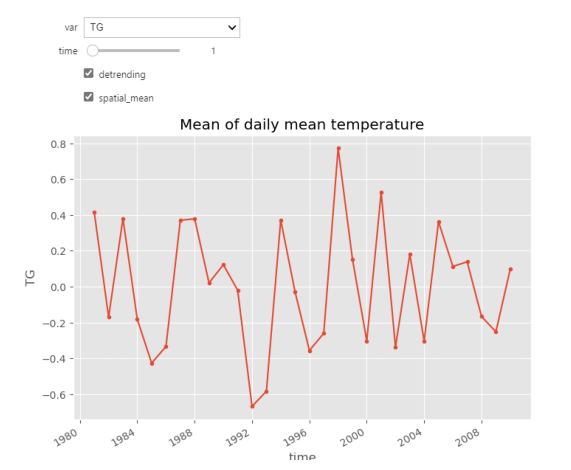

In [31]:
variables = [i for i in agro_clim.data_vars if i !='time_bounds']
variables.append('Yield')
interact(plot_spatial_mean, var=variables, time=(0,29,1))
plt.show()


# fig = plt.figure()

# # Get the images from the source and Plot them 
# ax = fig.add_subplot()
# img = plt.imread('../Figures/Ipywidgets1t2m.png')
# ax.imshow(img)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.axis("off")
# plt.tight_layout()
# plt.show()
# plt.close()

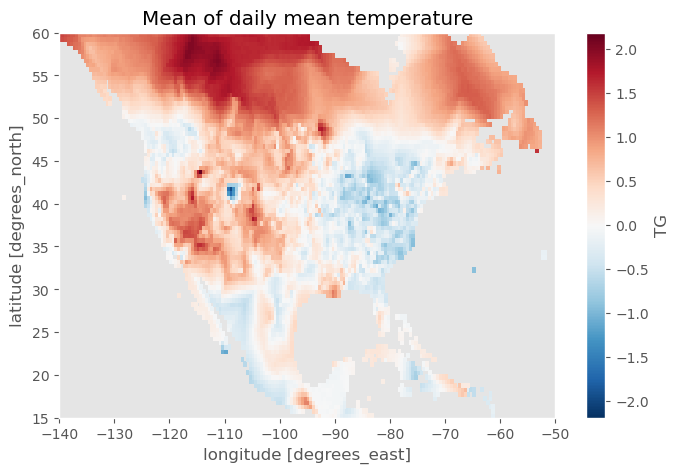

<Figure size 640x480 with 0 Axes>

In [32]:
# plot for github. For some reason widget status does no show up on github
plot_spatial_mean(var='TG', time=0, spatial_mean=False)
plt.show()
plt.savefig('US_TG.png')

### Detrending Agro-Climatic Indicators (Features)
<div class="span5 alert alert-warning">
The priority of this project is to investigate how crop yield is affected by weather conditions. Therefore interannual variability in yield is more important for this work than decadal variability where the latter is related not only Climate but also development in agricultural technologies and human beheviours.
    <p>Therofore, I will first detrend the predictors (agro-climatic indicators) and later the response variable (yield).</p>
    </div>

In [33]:
# applying detrend_2d function on all the variables in agro_clim dataset
agro_clim = agro_clim.map(detrend_2d, keep_attrs=True)

## Getting Climate For Product Zone
* Importing US-Census geospatial data for the county boundaries using __Geopandas package__ https://catalog.data.gov/dataset/u-s-county-boundaries
* Embedding county coordinates to Xarray climate dataset for county-level operations. 
* Masking climate dataset only to keep the selected counties using **Salem package**

In [34]:
# Read the shape file for US Counties using Geopandas package
path_geo = 'C:\\Users\\kurt_\\Data\\tl_2020_us_county\\'
counties_bound = geopandas.read_file(path_geo)
print('The coordinate Reference System Info:')
print(counties_bound.crs)

# Select the Arkansas county
counties_bound.head(2)

The coordinate Reference System Info:
epsg:4269


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."


In [35]:
counties_bound['COUNTYFP'].astype('int')

0        39
1        69
2        11
3       109
4       129
       ... 
3229    123
3230    135
3231     89
3232    227
3233     99
Name: COUNTYFP, Length: 3234, dtype: int32

<div class="span5 alert alert-info">
We have coordinates of US county boundaries in the geo_usa data, let's plot the mainland US on a map based on these coordinates to see if everyhting is alright.
    </div>

Double Click To Zoom In


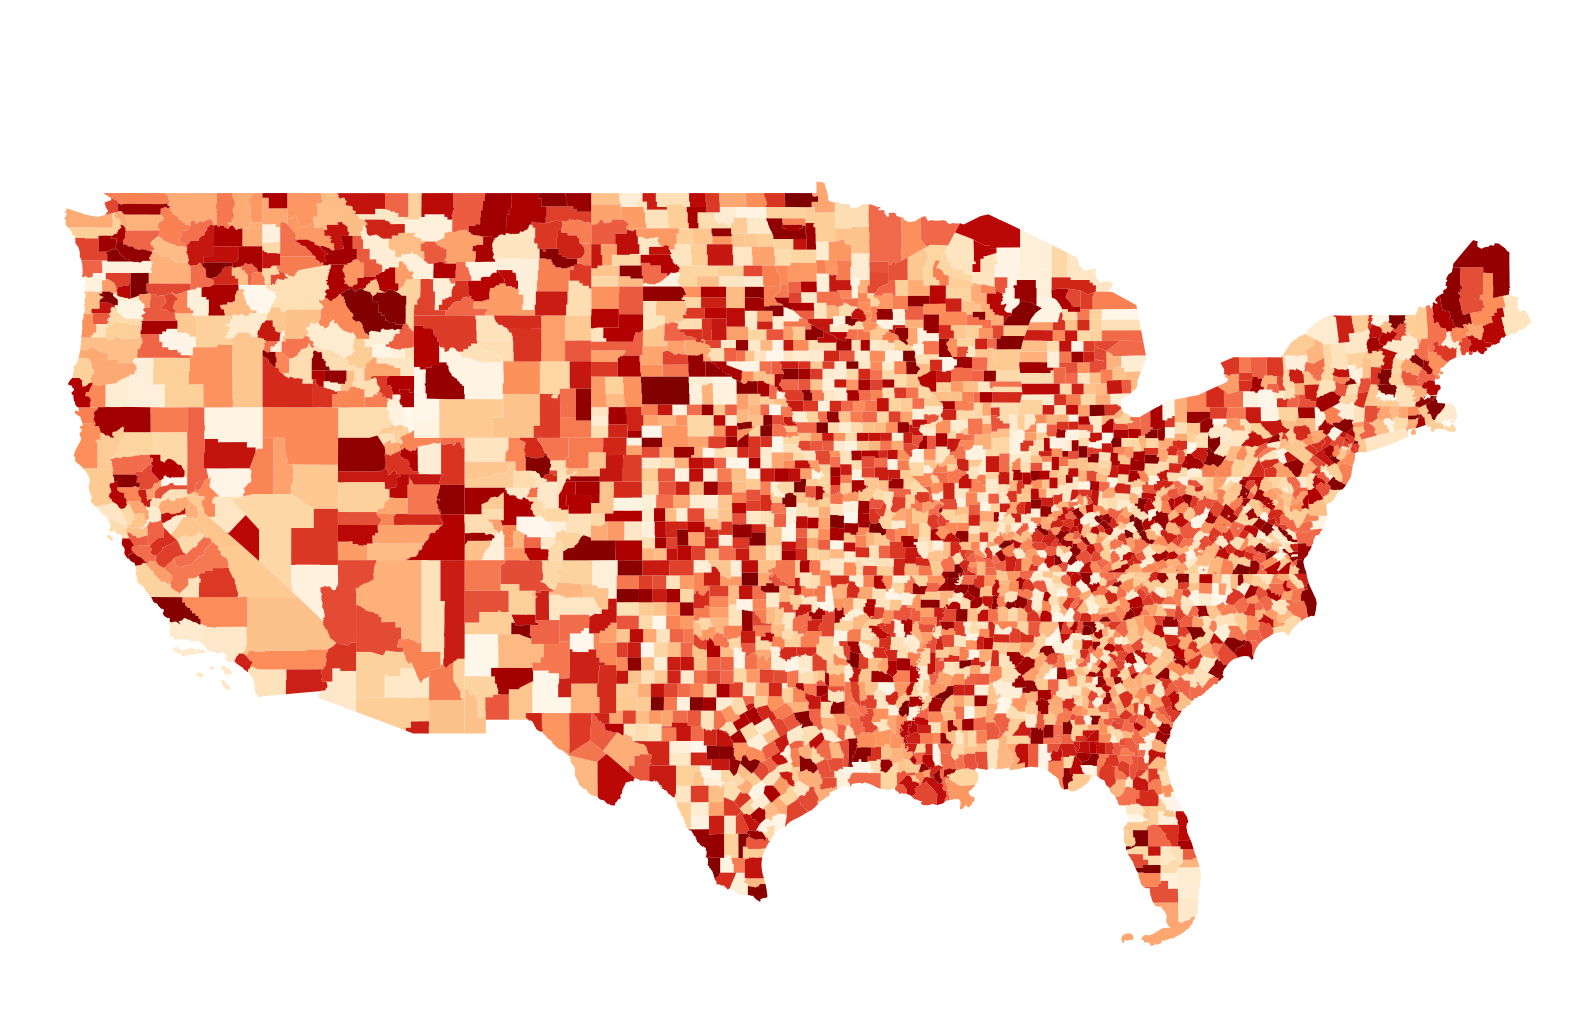

In [38]:
# Let's see the state boundaries on a map to see
# if there is an error

#Double click to zoom in / out
red = '\033[31;2;7m'
reset = '\033[0m'
print(red+"Double Click To Zoom In"+reset)

# # Getting rid of oversees territories from the map
counties_bound = counties_bound[counties_bound.STATEFP.apply(lambda x: int(x)) < 60]
#Let's remove the Alaska too
counties_bound = counties_bound[counties_bound.STATEFP != '02']

fig,ax = plt.subplots(figsize=(16, 12))
counties_bound.plot(ax=ax, cmap='OrRd')
ax.set_xlim(-127,-65)
ax.set_ylim(22,55)
ax.set_yticks([])
ax.set_xticks([])
ax.axis("off")
# counties_bound.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1);
plt.tight_layout()
plt.show()
plt.close()

#### Calculating County Means
<div class="span5 alert alert-info">
    <ul>
        <li>Convert state and county code columns in the county_bound data to numeric.</li>
        <li>Create a new unique County ID in counties_bound like it was done for df_soy data above so that counties with the same name can be separeted ( Note that counties with the same name also have the same ANSI code)
        <li> Define a function to calculate county-wise spatial means .</li>
    This will reduce the space-time data to a simple time-series for each state.
        <li>Then let's plot 2-d temperature variable of the counties on a random day to make sure that everything is fine.</li>
</div>

Convert state and county code columns in the county_bound data to numeric.  to match the soy beans yield data. This will enable us to select the region of interest in the climate data.

In [68]:
# COUNTYFP and STATEFP are object type. Let's convert to numeric.
counties_bound['COUNTYFP'] = pd.to_numeric(counties_bound['COUNTYFP'])
counties_bound['STATEFP'] = pd.to_numeric(counties_bound['STATEFP'])
# Create a unique ID for each counties just as we did in df_soy data
counties_bound['County_ID'] = counties_bound['STATEFP']*1000 + counties_bound['COUNTYFP']


In [ ]:
counties_bound[(counties_bound.COUNTYFP == 35) & 
               (counties_bound.STATEFP == 5)]

In [77]:
county_shape_path = os.path.join('C:\\'
                'Users',
                'kurt_',
                'Data',
                'tl_2020_us_county',
                 'tl_2020_us_county.shp')
us_states = salem.read_shapefile(county_shape_path)
type(counties_bound)

geopandas.geodataframe.GeoDataFrame

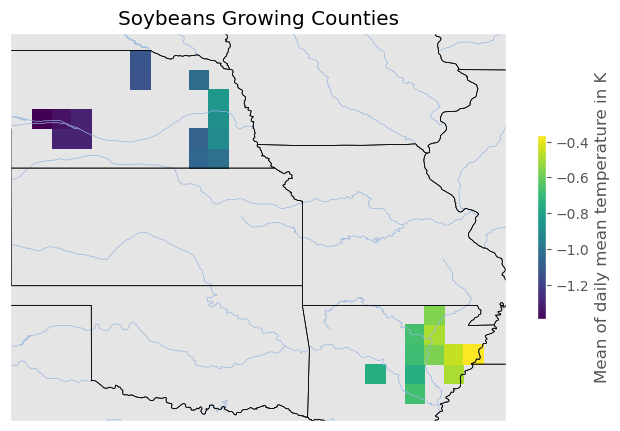

In [84]:
def sel_counties(dt, var=None, counties='all', _plot=False):
    """Calculate state climate and Plot the region of interest from 
    the list of 'state' list. 
    var: which variable to plot. kywrd:
            Default = None: Do not plot any variables. if _plot=True a variable name has to be given instead
    state: which state to select. Default is 'all': all the states in df_soy 
            state_name: Manually select states. State names should be a list of strings """
    # Getting State names
    if counties not in ['all', 'crop']: # user selected counties
        soy_counties = counties
    elif counties == 'all':
        soy_counties = list(df_soy['County_ID'].unique())

    # Subsetting the counties shapefile to match yield data
    county_coordinates = counties_bound[(counties_bound['County_ID'].isin(soy_counties))]

    # Extracting only the region of interest from climate data
    county_clim = dt.salem.subset(shape=county_coordinates, 
                                 margin=0).salem.roi(shape=county_coordinates)
    
    # plotting the region of interest
    if _plot == True:
        plt.style.use('seaborn-colorblind')

        # Creating Figures
        fig = plt.figure(figsize=(8,6))

        # plotting on a map using cartopy
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
        ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
        ax.add_feature(cartopy.feature.RIVERS)
        ax.add_feature(cartopy.feature.STATES)


        # Let's plot the variable at a random time
        randm_day = county_clim[var].isel( time=
                                         np.random.randint(len(county_clim.time)))

        # randm_day.salem.roi(shape=state_coord).plot(ax=ax)
    #     randm_day = randm_day.salem.roi(shape=state_coord)
        plt.pcolormesh(randm_day.lon, randm_day.lat, randm_day)

        cb = plt.colorbar(shrink=0.4) # use shrink to make colorbar smaller
        cb.set_label(f"{dt[var].long_name} in {dt[var].units}")

        plt.title(f'Soybeans Growing Counties')
    return county_clim
# let's see the sel_counties function to get and plot the climate for counties where soybeans are grown

county_clim = sel_counties(agro_clim, var='TG', 
                           counties='all', _plot=True)
# plt.savefig('soybeans_states2dTG.png')
plt.show()

In [85]:
df_soy['County_ID'].value_counts(),k

5121     31
31151    31
5111     31
5107     31
5077     31
5075     31
5069     31
5067     31
5037     31
5035     31
31179    31
31159    31
5123     31
31155    31
31053    31
31095    31
31067    31
31089    31
5117     31
31109    31
31097    30
5063     30
31039    30
5147     30
5079     30
5085     30
5145     30
31127    30
31111    23
5071     20
5125     13
Name: County_ID, dtype: int64

#### Converting Xarray datasets to DataFrames
* Using `sel_states` function those states where soybeans are grown will be selected individually
* `spatial_mean` function will be used to take the proper spatial mean of each state along lat-lon dims.
    (This will produce a simple time series data for each state.)
* All the datasets will be converted to a dataframe

In [67]:
soy_states = list(df_crop_srv[df_crop_srv['Commodity'] == "SOYBEANS"]
                       .State.unique())

state_clim_list = []
for state in soy_states:
    state_clim = sel_states(agro_clim, file_path=coord_file,
                            crop='SOYBEANS', states=state)
    
    # Calculate correct spatial mean for the state
    state_clim = grid_mean(state_clim) # only dimension is time now
    
    # convert the state_clim to a dataframe
    state_clim = state_clim.to_dataframe()
    
    # add state name as a new column    
    # fill the State column with ones
    state_clim['State'] = np.ones(len(state_clim))
    
    # replace the ones with the state name
    state_clim['State'].replace(1, state, inplace=True)

    # collect state-mean datasets in a list to unpack later
    state_clim_list.append(state_clim)
    
# let's name each data set in the state_clim_list by their corresponding state name abbrevition
il_agro_clim, in_agro_clim, ia_agro_clim, nd_agro_clim =  state_clim_list
# let's concat all the states data in clim_ind (short for climate indicators)
clim_ind = pd.concat(state_clim_list, axis=0)

Finally save the climate indicators and the soybeans yield dataframes to disk to use in the feature engineering step

In [76]:
# Let's pickle the final dataframes
clim_ind.to_pickle('Data/clim_ind.pkl')
df_soy.to_pickle('Data/df_soy.pkl')

### Detrending Agro-Climatic Indicators (Features)
<div class="span5 alert alert-warning">
Since this study is only about anomalies after all the trends are removed detrending before splitting the data to train and test wouldn't cause any significant data leakage because trends in the data are mostly related to external factors such as technological development, human behaviours etc. rather than climate change which happens to have similar trend (although not by chance, they do not have direct cause and effect relationship in the context of crop yield). </div>

In [143]:
# Soybeans states from the crop data
soy_states = list(soy_yield.State.unique())

In [146]:
# Select years matching clim_ind 
year_first = clim_ind.index[0].year
year_last = clim_ind.index[-1].year
soy_yield = soy_yield[(soy_yield.Year >= year_first) & 
                      (soy_yield.Year <= year_last)]


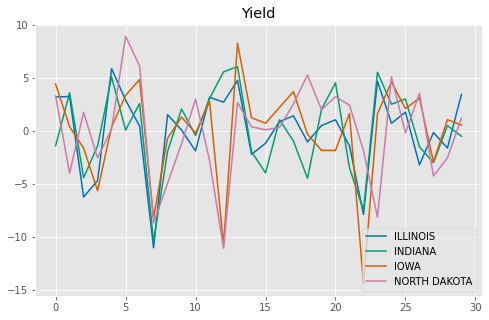

In [189]:
states = iter(soy_states)
def plot_var(var):
    fig, ax = plt.subplots(figsize=(8,5))
    for df in df_list:# state_clim_list:
        stt = next(states)
        if var == 'Value':
            df[var].reset_index(drop=True).plot(ax=ax, label=stt)
            plt.title('Yield')
        else:
            df[var].plot(ax=ax, label=stt)
            plt.title(agro_clim[var].long_name)
    return
        
        
# interact(plot_var, var=['TG','RR1','SU']) # clim_ind.columns.values
plot_var('Value')
plt.legend()
plt.show()
#interact plots don't appear on github
# plot_var('GSL')

### Collecting features and response in the same data frame
* Select the years in df_soy matching climate data
* Merge all climate and yield data together

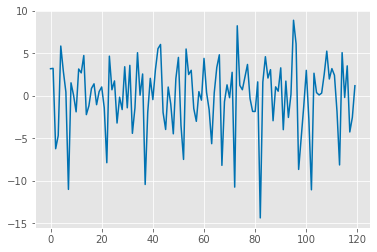

In [176]:
# create new dataframe with features and response variables
value = soy_yield['Value'].copy()
# match datetime index for properly joining value columns
value.index = clim_ind.index
df = clim_ind.copy()
df['Yield']  = value

# we don't need datetime index anymore, let's just move it to a column
df = df.reset_index()
df['Yield'].plot()
plt.show()

In [190]:
# Saving df to disk
df.to_pickle('Data/all_variables.pkl')

In [ ]:
df_pt_train = pd.read_pickle('Data/df_pt_train.pkl')
df_pt_train = pd.read_pickle('Data/df_pt_train.pkl')

In [140]:
def sel_plot_states(_time=1,var='TG'):
    """Calculate state climate and Plot the region of interest from 
    the list of 'state' list. 
    var: which variable to plot. kywrd:
            Default = None: Do not plot any variables. if _plot=True a variable name has to be given intead
    state: which state to select. Default is 'all': all the states in df_crop 
            'crop': only the states for the selected crop
            state_name: Manually select states. State names should be a list of strings """
    # Getting State names
    dt=agro_clim 
    crop='SOYBEANS'
    file_path = path_geo+'cb_2018_us_state_500k.shp'
    states='crop'
    _plot=True
    if states not in ['all', 'crop']: # user selected states
        crop_states = [states.title()]  # just convert to upper case
    elif states == 'all':
        crop_states = list(df_crop_srv.State.unique())
        crop_states = [x.title() for x in crop_states]
    elif states == 'crop':
        crop_states = list(df_crop_srv[df_crop_srv['Commodity'] == crop]
                           .State.unique())
        crop_states = [x.title() for x in crop_states]
#     print(f'{crop} states: {crop_states}')
    # Reading state shape files from census data using Salem
    us_states = salem.read_shapefile(file_path)
    state_coord = us_states[(us_states.NAME.isin(crop_states))]

    # Extracting only the region of interest from climate data
    state_clim = dt.salem.subset(shape=state_coord, 
                                 margin=5).salem.roi(shape=state_coord)
    
    # plotting the region of interest
    if _plot == True:
        plt.style.use('seaborn-colorblind')

        # Creating Figures
        fig = plt.figure(figsize=(8,6))

        # plotting on a map using cartopy
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
        ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
        ax.add_feature(cartopy.feature.RIVERS)
        ax.add_feature(cartopy.feature.STATES)

        # State names on the map
        state_coord.apply(lambda x: ax.annotate(text=x.NAME, 
                                                xy=x.geometry.centroid.coords[0], 
                                                ha='center', fontsize=7),axis=1);

        # Let's plot the variable at a random time
        randm_day = state_clim[var].isel(time=_time)

        # randm_day.salem.roi(shape=state_coord).plot(ax=ax)
    #     randm_day = randm_day.salem.roi(shape=state_coord)
        plt.pcolormesh(randm_day.lon, randm_day.lat, randm_day)

        cb = plt.colorbar(shrink=0.4) # use shrink to make colorbar smaller
        cb.set_label(f"{dt[var].long_name} in {dt[var].units}")

        plt.title(f'Year = {str(randm_day.time.dt.year.values)}')
        
    return state_clim
# let's see the sel_states function to get and plot the states where soybeans are grown
# coord_file = path_geo+'cb_2018_us_state_500k.shp'
# state_clim = sel_states(agro_clim,crop='SOYBEANS', 
#                         file_path = coord_file,var='CWD', states='crop', _plot=True)
# plt.show()

In [80]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [141]:
coord_file = path_geo+'cb_2018_us_state_500k.shp'
interact(sel_plot_states , _time=(0,29,1), 
         var=['TG', 'RR1', 'SU']) # clim_ind.columns.values ['TG', 'RR1', 'SU']


interactive(children=(IntSlider(value=1, description='_time', max=29), Dropdown(description='var', options=('T…

<function __main__.sel_plot_states(_time=1, var='TG')>